## Random Acts of Pizza

W207 Final Project

Erika Lawrence, Leslie Teo, Jen Jen Chen, Geoff Stirling


_"The universe is hilarious. Like, Venus is 900 degrees. I could tell you it melts lead. But that's not as fun as saying, 'You can cook a pizza on the windowsill in nine seconds.' And next time my fans eat pizza, they're thinking of Venus!"_

_- Neil deGrasse Tyson_ 

----------------------------------------------------------------------

## Section 1: Setting Up & Processing Data

In [1]:
# For figures to show inline
%matplotlib inline

## Import Libraries ##

import json
from pprint import pprint
from pandas.io.json import json_normalize
import pandas as pd

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mlxtend
import scipy
import datetime as dt
from itertools import product

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# SK-learn libraries for pre/processing data
from sklearn import preprocessing

# NLTK for text processing, analyzing tools
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.util import *

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

# SK-lear library for feature selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectPercentile


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from mlxtend.classifier import EnsembleVoteClassifier

# SK-learn libraries for evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, recall_score


/home/levi/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
## Get Data ##

# Reference for data: https://www.kaggle.com/c/random-acts-of-pizza/data
# Pull in the training and test data
with open('data/train.json', encoding='utf-8') as data_file:
    trainData = json.loads(data_file.read())   

with open('data/test.json', encoding='utf-8') as data_file:
    testData = json.loads(data_file.read())    

# Create a dev data set 
devData = trainData[0:1000]
trainData = trainData[1000:]

# Show how the data looks in its original format
#pprint("data in json format:")
#pprint(trainData[1])

# Create a normalized view
allTData = json_normalize(trainData)
print("\nSize of the normalized Data:", allTData.shape)
print("\nnormalized data columns:", list(allTData))

allDData = json_normalize(devData)


Size of the normalized Data: (3040, 32)

normalized data columns: ['giver_username_if_known', 'number_of_downvotes_of_request_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 'post_was_edited', 'request_id', 'request_number_of_comments_at_retrieval', 'request_text', 'request_text_edit_aware', 'request_title', 'requester_account_age_in_days_at_request', 'requester_account_age_in_days_at_retrieval', 'requester_days_since_first_post_on_raop_at_request', 'requester_days_since_first_post_on_raop_at_retrieval', 'requester_number_of_comments_at_request', 'requester_number_of_comments_at_retrieval', 'requester_number_of_comments_in_raop_at_request', 'requester_number_of_comments_in_raop_at_retrieval', 'requester_number_of_posts_at_request', 'requester_number_of_posts_at_retrieval', 'requester_number_of_posts_on_raop_at_request', 'requester_number_of_posts_on_raop_at_retrieval', 'requester_number_of_subreddits_at_request', 'requester_received_pizza', 'requester_subreddits_at_request

(3040, 1)

Percent of people who got pizza: 0.241


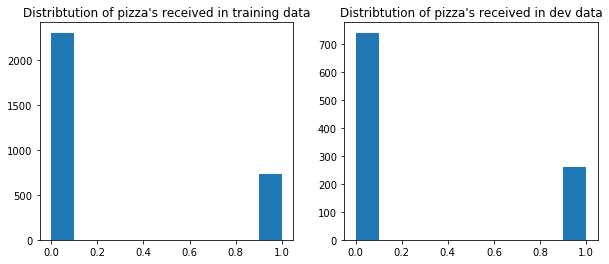

In [3]:
## Create subsets of data for analysis ###

# Create a flat dataset without the subreddits list
flatData = allTData.drop('requester_subreddits_at_request', 1)
# Create a separate dataset with just subreddits, indexed on request id
# We can creata a count vector on the words, run Naive Bayes against it, 
# and add the probabilities to our flat dataset
subredTData = allTData[['request_id','requester_subreddits_at_request']]
subredTData.set_index('request_id', inplace=True)

subredDData= allDData[['request_id','requester_subreddits_at_request']]
subredDData.set_index('request_id', inplace=True)

# our training labels
trainLabel = allTData['requester_received_pizza']

devLabel = allDData['requester_received_pizza']

# What do these look like?
#print(list(flatData))
print(subredTData.shape)
#print(subredTData['requester_subreddits_at_request'][1])

# Create a corpus of subreddits to vectorize
trainCorpus = []
rTCorpus = []
rDCorpus = []

for index in range(len(subredTData)):
    trainCorpus.append(' '.join(subredTData['requester_subreddits_at_request'][index]))
    rTCorpus.append(' '.join(subredTData['requester_subreddits_at_request'][index]))

devCorpus = []
for index in range(len(subredDData)):
    devCorpus.append(' '.join(subredDData['requester_subreddits_at_request'][index]))
    rDCorpus.append(' '.join(subredDData['requester_subreddits_at_request'][index]))

# Baseline infofrom mlxtend.plotting import plot_decision_regions
print("\nPercent of people who got pizza:", round(sum(trainLabel)/len(trainLabel),3))

plt.figure(1,figsize=(10,4))
plt.subplot(121)
plt.hist(allTData['requester_received_pizza'])
plt.title("Distribtution of pizza's received in training data")
plt.subplot(122)
plt.hist(allDData['requester_received_pizza'])
plt.title("Distribtution of pizza's received in dev data")

In [4]:
# combine all text sources into a single corpus

fldTText = allTData[['request_title', 'request_text']]
fldDText = allDData[['request_title', 'request_text']]
#fldDText = allDData[['request_id','request_text', 'request_text_edit_aware', 'request_title']]

#print(fldTText[:3])
#print(fldDText['request_text'][:3])
#print(len(fldTText))

trainCorpus = []
for index in range(len(fldTText)):
    a = ''.join(fldTText['request_title'][index])
    b = (a, fldTText['request_text'][index])
    trainCorpus.append(' '.join(b))
                          
devCorpus = []
for index in range(len(fldDText)):
    a = ''.join(fldDText['request_title'][index])
    b = (a, fldDText['request_text'][index])
    devCorpus.append(' '.join(b))
    

# Print 3 examples  
print(len(trainCorpus))
print(trainCorpus[:3])
#labels = trainLabel.astype(int)
#labels = list(labels)
#print(labels[:3])
#print('-'*75)

print(len(devCorpus))
print('\n' , devCorpus[:3])
#labels_dev = devLabel.astype(int)
#labels_dev = list(labels_dev)
#print(labels_dev[:3])

3040
["[Request] Just got dumped, no food in the freezer. Pizza? So it's been a while since it's happened, but yeah. Just got dumped by a girl I like... My brother has used up pretty much everything in the freezer. I would really appreciate a pizza right now...", "[Request]  Saint Augustine, US.  Boyfriend and I have no money till next week, and are awaiting food stamps approval. My boyfriend and I live in Saint Augustine, Florida and have been having a rough time financially the past few months.  In and out of various jobs, we've had to survive off of coscto sized ramen packs, and pasta and olive oil.  I applied for food stamps a couple days ago, and am waiting to hear back from them.  It's getting a little trite, and we're quite hungry tonight, a hot pizza would be a delight.  We'll happily pay it forward in the future.  Much love.", "[Request] I'd love a Buffalo Chicken Puzza! I seriously love buffalo chicken pizza. Like, straight up addicted. There's a local pizzeria that delivers 

## Section 2: Feature Extraction - Text, then Others
We now extract features from text and other characteristics of the post. We find that time is one indicator that seems to have good explanatory power.

### Section 2.0: Simple pre-processing function

In [5]:
# Simple Pre-Processing Function

def data_preprocessor(s):
    """
    Note: this function pre-processors data:
    (1) removes non-alpha characters
    (2) converts digits to 'number'
    (3) regularizes spaces (although CountVectorizer ignores this unless they are part of words)
    (4) reduces word size to n
    """

    s = [re.sub(r'[?|$|.|!|@|\n|(|)|<|>|_|-|,|\']',r' ',s) for s in s] # strip out non-alpha numeric char, replace with space
    s = [re.sub(r'\d+',r'number ',s) for s in s] # convert digits to number
    s = [re.sub(r' +',r' ',s) for s in s] # convert multiple spaces to single space
    
    # This sets word size to n=8
    num = 8
    def size_word(s):
        temp = []
        for s in s:
            x = s.split()
            z = [elem[:num] for elem in x]
            z = ' '.join(z)
            temp.append(z)       
        return temp
    
    # Using NLTK 3.0 
    
    #stemmer = PorterStemmer()
    lemmanizer = WordNetLemmatizer()
    
    def set_word(s):
        temp = []
        for s in s:
            #x = stemmer.stem(s)
            z = lemmanizer.lemmatize(s,pos='v')
            z = ''.join(z)
            temp.append(z)
        return temp
    
    s = size_word(s)
    s = set_word(s)
    
    
    return s



### Section 2.1: Tokenization (for text) 
After trying unigram and trigram vectorizers, the best results were found using bigrams in logistic regression


In [6]:
# Try it with bigrams 
# Create the vectorizer
vectorizer = CountVectorizer(min_df=2, max_df=0.95, lowercase=True, stop_words='english', 
                             strip_accents='unicode', ngram_range=(1,2))

# Transform the corpus into vectorized trigrams
tVector = vectorizer.fit_transform(data_preprocessor(trainCorpus))
dVector = vectorizer.transform(data_preprocessor(devCorpus))

# How does it look?
print ('\nRaw data:')
print ("The size of the vocabulary for the training text data is", tVector.shape[1])
print ("First 5 feature Names:", vectorizer.get_feature_names()[1:6], "\n")

# Use the preprocessor and do the same
vectorizer_p = TfidfVectorizer(min_df=2, max_df=0.95, lowercase=True, stop_words='english', 
                             strip_accents='unicode', ngram_range=(1,2))

tVector_p = vectorizer_p.fit_transform(data_preprocessor(trainCorpus))
dVector_p = vectorizer_p.transform(data_preprocessor(devCorpus))

# How does the pre-processed vector look?
print ('\nRaw data:')
print ("The size of the vocabulary for the training text data is", tVector_p.shape[1])
print ("First 5 feature Names:", vectorizer_p.get_feature_names()[1:6], "\n")


Raw data:
The size of the vocabulary for the training text data is 17092
First 5 feature Names: ['ab', 'ab canada', 'abandone', 'abc', 'abdomina'] 


Raw data:
The size of the vocabulary for the training text data is 17092
First 5 feature Names: ['ab', 'ab canada', 'abandone', 'abc', 'abdomina'] 



### Section 2.2 PCA
Given the sparse matrix, we apply PCA to reduce dimensionality for the text features

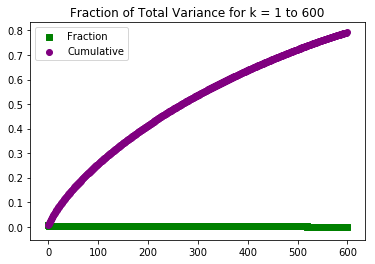

In [7]:
# PCA, we tried PCA with dense() as well as TruncatedSVD; the latter works better in explaining variance

n_comp = 600
pca_mod = PCA(n_components=600)
#pca_mod = TruncatedSVD(n_components=600)

tVector_s = pca_mod.fit_transform(tVector.todense())
dVector_s = pca_mod.fit_transform(dVector.todense())

tVector_ps = pca_mod.fit_transform(tVector_p.todense())
dVector_ps = pca_mod.fit_transform(dVector_p.todense())

# Find the fraction of the variance explained by each component
pcaVarRatio =  pca_mod.explained_variance_ratio_ 
pcaCumVarRatio =  np.cumsum(pca_mod.explained_variance_ratio_)
   
# Plot the fraction of variance explained by each component, and the cumulative percent 
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(range(len(pcaVarRatio)), pcaVarRatio, c = 'g', marker="s", label='Fraction')
ax1.scatter(range(len(pcaVarRatio)), pcaCumVarRatio, c = 'purple',marker="o", 
            label='Cumulative')
plt.legend(loc='upper left');
ax1.set_title('Fraction of Total Variance for k = 1 to 600');


### Section 2.3:  Adding Other Features

1) Up votes, downvotes
2) Number of commments, posts
3) Account Age
4) Time - Month
5) Time - Hour
6) Vadersentiment


(3040, 14) (3040, 2)
(1000, 14) (1000, 2)
(3040, 17)
(1000, 17)


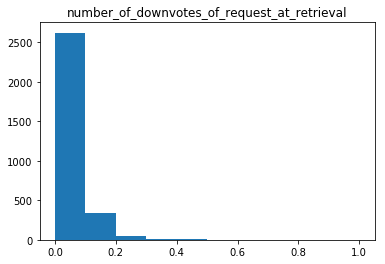

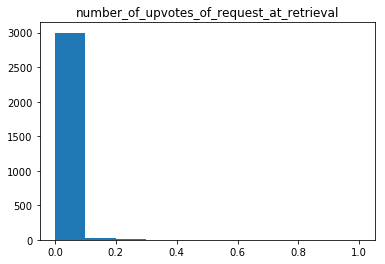

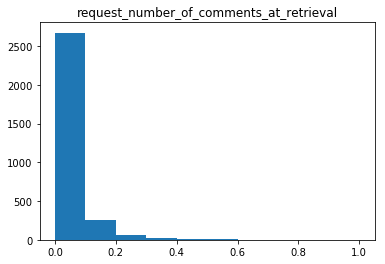

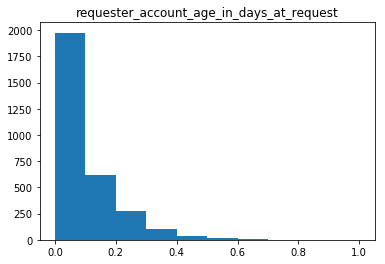

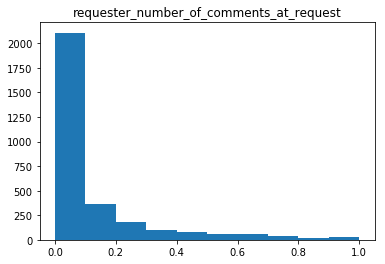

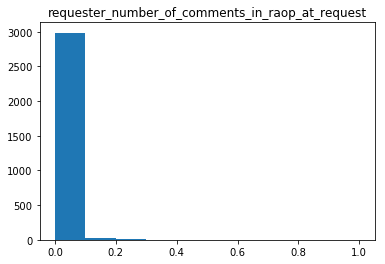

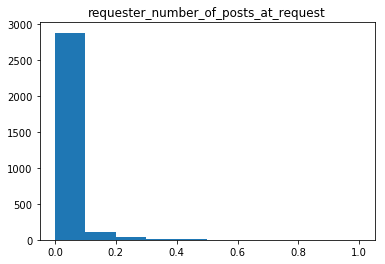

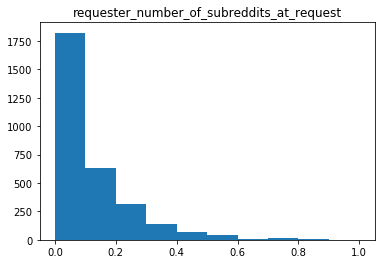

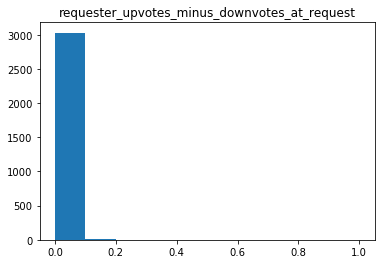

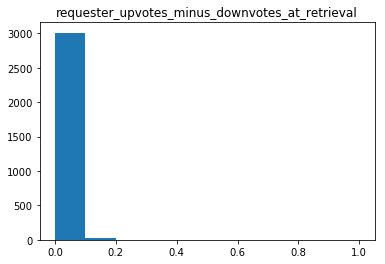

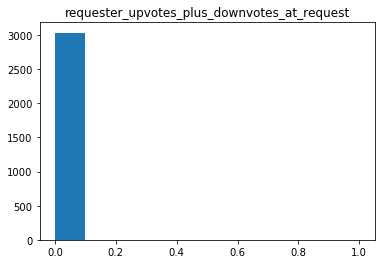

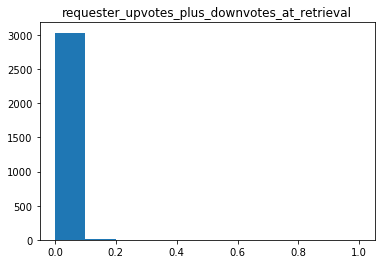

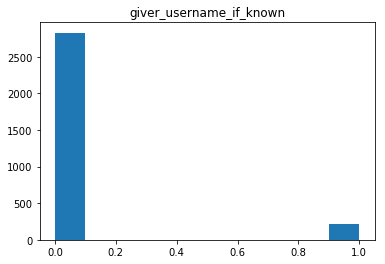

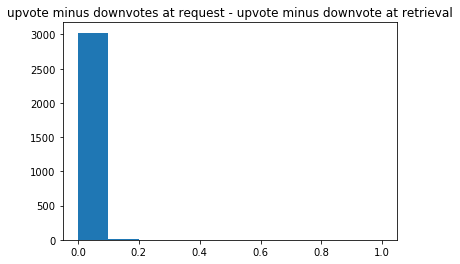

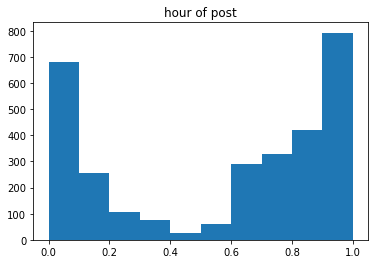

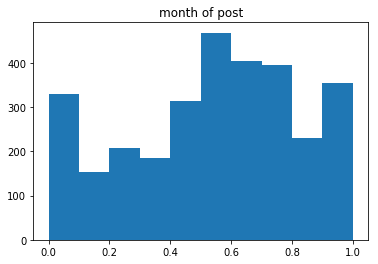

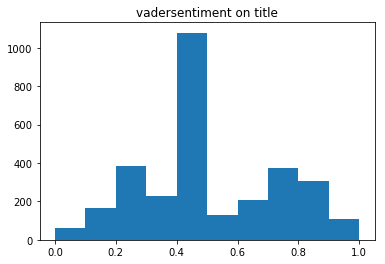

In [8]:
# Extract other features

def plot_figure(x,desc):
    plt.figure()
    plt.title(desc)
    plt.hist(x)
    

subTTFe = allTData[['giver_username_if_known', 
                    'number_of_downvotes_of_request_at_retrieval', 
                    'number_of_upvotes_of_request_at_retrieval',
                    'request_number_of_comments_at_retrieval',
                    'requester_account_age_in_days_at_request',
                    'requester_number_of_comments_at_request', 
                    'requester_number_of_comments_in_raop_at_request', 
                    'requester_number_of_posts_at_request', 
                    'requester_number_of_subreddits_at_request', 
                    'requester_upvotes_minus_downvotes_at_request', 
                    'requester_upvotes_minus_downvotes_at_retrieval', 
                    'requester_upvotes_plus_downvotes_at_request', 
                    'requester_upvotes_plus_downvotes_at_retrieval']]

subDTFe = allDData[['giver_username_if_known', 
                    'number_of_downvotes_of_request_at_retrieval', 
                    'number_of_upvotes_of_request_at_retrieval',
                    'request_number_of_comments_at_retrieval',
                    'requester_account_age_in_days_at_request',
                    'requester_number_of_comments_at_request', 
                    'requester_number_of_comments_in_raop_at_request', 
                    'requester_number_of_posts_at_request', 
                    'requester_number_of_subreddits_at_request', 
                    'requester_upvotes_minus_downvotes_at_request', 
                    'requester_upvotes_minus_downvotes_at_retrieval', 
                    'requester_upvotes_plus_downvotes_at_request', 
                    'requester_upvotes_plus_downvotes_at_retrieval']]

# Convert first col to numerical

temp = 1*(subTTFe['giver_username_if_known']!='N/A').values
subTTFe = subTTFe.drop('giver_username_if_known',1).values

temp = np.reshape(temp,(-1,1))
subTTFe = np.concatenate((subTTFe,temp), axis=1)

#print(subTTFe[1])

temp = 1*(subDTFe['giver_username_if_known']!='N/A').values
subDTFe = subDTFe.drop('giver_username_if_known',1).values

temp = np.reshape(temp,(-1,1))
subDTFe = np.concatenate((subDTFe,temp), axis=1)

# Create new features

# Upvote minus downvotes at request - upvote minus downvote at retrieval

temp = np.reshape((subTTFe[:,10] - subTTFe[:,9]),(-1,1))
subTTFe = np.concatenate((subTTFe,temp),axis=1)

temp = np.reshape((subDTFe[:,10] - subDTFe[:,9]),(-1,1))
subDTFe = np.concatenate((subDTFe,temp),axis=1)

# Hour and Month of request

unixT = allTData[['unix_timestamp_of_request_utc']].copy()
unixD = allDData[['unix_timestamp_of_request_utc']].copy()

# Convert from unix > datetime
unixT['Datetime'] = pd.to_datetime(unixT['unix_timestamp_of_request_utc'], unit='s')
unixT['Hour'] = unixT['Datetime'].dt.hour
unixT['Month'] = unixT['Datetime'].dt.month
unixT = unixT.drop(['Datetime','unix_timestamp_of_request_utc'], axis=1)
unixT = unixT.values

unixD['Datetime'] = pd.to_datetime(unixD['unix_timestamp_of_request_utc'], unit='s')
unixD['Hour'] = unixD['Datetime'].dt.hour
unixD['Month'] = unixD['Datetime'].dt.month
unixD = unixD.drop(['Datetime','unix_timestamp_of_request_utc'], axis=1)
unixD = unixD.values

print(subTTFe.shape, unixT.shape)
print(subDTFe.shape, unixD.shape)

subTTFe = np.concatenate((subTTFe,unixT),axis=1)
subDTFe = np.concatenate((subDTFe,unixD),axis=1)


# Create sentiment score using vader sentiment analysis

titles = allTData['request_title']

analyzer = SentimentIntensityAnalyzer()
    
scores = []

for title in titles:
    x = analyzer.polarity_scores(title)
    scores.append(x['compound'])  

subTTFe = np.concatenate((subTTFe,np.reshape(scores,(-1,1))),axis=1)

scores = []

titles = allDData['request_title']    
    
for title in titles:
    x = analyzer.polarity_scores(title)
    scores.append(x['compound'])      
    
subDTFe = np.concatenate((subDTFe,np.reshape(scores,(-1,1))),axis=1)
    
print(subTTFe.shape)
print(subDTFe.shape)

# Scale features

#print(describe(subTTFe[:,0]))

n1 = preprocessing.MinMaxScaler().fit_transform(subTTFe)
n2 = preprocessing.MinMaxScaler().fit_transform(subDTFe)

#print(n1.shape)

list = ['number_of_downvotes_of_request_at_retrieval', 
        'number_of_upvotes_of_request_at_retrieval',
        'request_number_of_comments_at_retrieval',
        'requester_account_age_in_days_at_request',
        'requester_number_of_comments_at_request', 
        'requester_number_of_comments_in_raop_at_request', 
        'requester_number_of_posts_at_request', 
        'requester_number_of_subreddits_at_request', 
        'requester_upvotes_minus_downvotes_at_request', 
        'requester_upvotes_minus_downvotes_at_retrieval', 
        'requester_upvotes_plus_downvotes_at_request', 
        'requester_upvotes_plus_downvotes_at_retrieval',
        'giver_username_if_known',
        'upvote minus downvotes at request - upvote minus downvote at retrieval',
        'hour of post', 'month of post', 'vadersentiment on title']

for i in range(n1.shape[1]):
    plot_figure(n1[:,i],list[i])



## Section 3:  Feature Selection
We combine text features and other features and do some selection (turns out less is better here)

In [9]:
# We apply some feature selection to tVector and dVector (text) which did not go through PCA

# Variancethreshold
"""
sel = VarianceThreshold(threshold=(0.8*(1-0.8)))
tVector = sel.fit_transform(tVector)
dVector = sel.transform(dVector)
"""

# Select k best
#sel = SelectKBest(chi2, k=8)

# Select percentile
sel = SelectPercentile(mutual_info_classif, percentile=10)

tVector = sel.fiprint(len(list))t_transform(tVector,trainLabel)
tVector_p = sel.fit_transform(tVector_p,trainLabel)
dVector = sel.fit_transform(dVector,devLabel)
dVector_p = sel.fit_transform(dVector_p,devLabel)

#nb = BernoulliNB(alpha=0.01).fit(tVector,trainLabel)
#model = SelectFromModel(nb, prefit=True)
#tVector = model.transform(tVector)
#dVector = model.transform(dVector)


print(tVector.shape)
print(dVector.shape)
print(tVector_p.shape)
print(dVector_p.shape)

(3040, 1709)
(1000, 1709)
(3040, 1709)
(1000, 1709)


In [10]:
# Commbine text features with other features
# We have one text feature that has undergone PCA
# Another which we used SelectPercentile()

tVector = np.concatenate((tVector.toarray(),n1),axis=1)
tVector_p = np.concatenate((tVector_p.toarray(),n1),axis=1)
dVector = np.concatenate((dVector.toarray(),n2),axis=1)
dVector_p = np.concatenate((dVector_p.toarray(),n2),axis=1)

tVector_s = np.concatenate((tVector_s,n1),axis=1)
tVector_ps = np.concatenate((tVector_ps,n1),axis=1)
dVector_s = np.concatenate((dVector_s,n2),axis=1)
dVector_ps = np.concatenate((dVector_ps,n2),axis=1)

print(tVector.shape)
print(dVector.shape)
print(tVector_p.shape)
print(dVector_p.shape)

print(tVector_s.shape)
print(dVector_s.shape)
print(tVector_ps.shape)
print(dVector_ps.shape)

(3040, 1726)
(1000, 1726)
(3040, 1726)
(1000, 1726)
(3040, 617)
(1000, 617)
(3040, 617)
(1000, 617)


## Section 4: Models
We tried the following models are a priori we thought a Logistic Regression or Naive Bayes would work well:

1. SVM
2. AdaBoost
3. Logistic Regression
4. Nearest Neighbor
5. Naive Bayes
6. Decision Tree
7. Random Forest

In this section we show the most promising models, Logistic Regression, Random Forest, and and ensemble approach.


In [11]:
def roc_curve1(y_true, y_pred_prob):
    """This function plots the ROC curve
    Inputs: y_true, correct label
            y_pred_prob, predicted probabilities
    """
    fpr, tpr, thr = roc_curve(y_true, y_pred_prob)
   
    thr = np.arange(0,1,1/100)
    plt.figure()
    plt.plot(fpr,tpr, 'r', thr, thr, 'b:')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC Curve")
    plt.show()
    

def score_rep(y_true, y_pred, desc):
    """Function to print out comprehensive report for classification test
    Inputs: y_true, correct label
            y_pred, predicted label from model
            desc, description of model
    Output: classification report
    """
    print(desc)
    print("-"*75)
    print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
    print("Area under curve of ROC: ", metrics.roc_auc_score(y_true, y_pred))
    print("Classification report:\n")
    print(metrics.classification_report(y_true, y_pred))
    print("-"*75)
    


### 4.1: Logistic Regression
We show our application to four data variants -

1) tVector, dVector -  based on CountVectorizer & some feature selection
2) tVector_p, dVector_p - basedon on TdifVectorizer & some feature selection
3) tVector_s, dVector_s - based on CounVectorizer & PCA
4) tVector_ps, dVector_ps - based on TdifVectorizer & PCA 

**We find that the first variant works well enough** (We also ran other experiments.)

Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.8
Area under curve of ROC:  0.621621621622
Classification report:

             precision    recall  f1-score   support

      False       0.79      0.99      0.88       740
       True       0.93      0.25      0.39       260

avg / total       0.83      0.80      0.75      1000

---------------------------------------------------------------------------


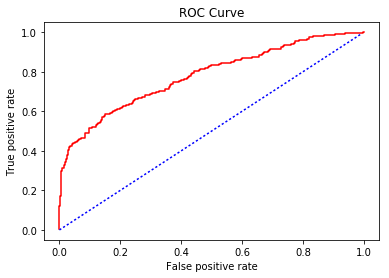

Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.769
Area under curve of ROC:  0.555769230769
Classification report:

             precision    recall  f1-score   support

      False       0.76      1.00      0.86       740
       True       1.00      0.11      0.20       260

avg / total       0.82      0.77      0.69      1000

---------------------------------------------------------------------------


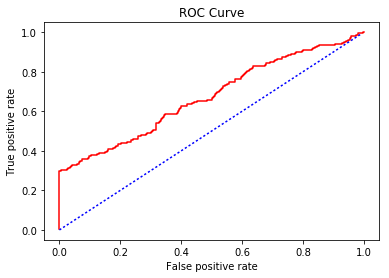

Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.762
Area under curve of ROC:  0.569750519751
Classification report:

             precision    recall  f1-score   support

      False       0.77      0.97      0.86       740
       True       0.67      0.17      0.27       260

avg / total       0.74      0.76      0.70      1000

---------------------------------------------------------------------------


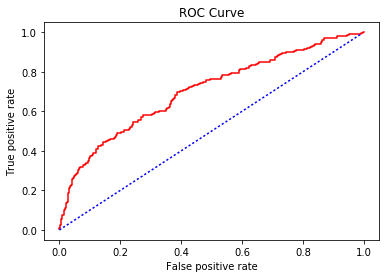

Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.768
Area under curve of ROC:  0.553846153846
Classification report:

             precision    recall  f1-score   support

      False       0.76      1.00      0.86       740
       True       1.00      0.11      0.19       260

avg / total       0.82      0.77      0.69      1000

---------------------------------------------------------------------------


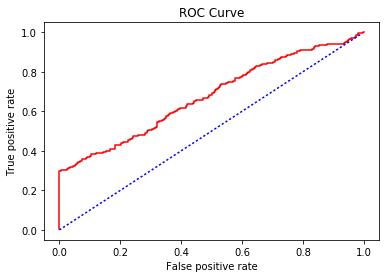

In [12]:
# Logistic Regression which we apply to four variants of the data


C = 0.01 #(For now)

modelLogit = LogisticRegression(penalty='l2', C=C)

modelLogit.fit(tVector,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector),'Logistic Regression, C = 0.01')
roc_curve1(devLabel, modelLogit.decision_function(dVector))

modelLogit.fit(tVector_p,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector_p),'Logistic Regression, C = 0.01')
roc_curve1(devLabel, modelLogit.decision_function(dVector_p))

modelLogit.fit(tVector_s,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector_s),'Logistic Regression, C = 0.01')
roc_curve1(devLabel, modelLogit.decision_function(dVector_s))

modelLogit.fit(tVector_ps,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector_ps),'Logistic Regression, C = 0.01')
roc_curve1(devLabel, modelLogit.decision_function(dVector_ps))

### Section 4.1: Logistic Regression - Grid Search
We now explore tuning C for Logistic Regression

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Logistic Regression with C=10, Tuned by GridSearch
---------------------------------------------------------------------------
Accuracy:  0.748
Area under curve of ROC:  0.731185031185
Classification report:

             precision    recall  f1-score   support

      False       0.88      0.77      0.82       740
       True       0.51      0.70      0.59       260

avg / total       0.78      0.75      0.76      1000

---------------------------------------------------------------------------


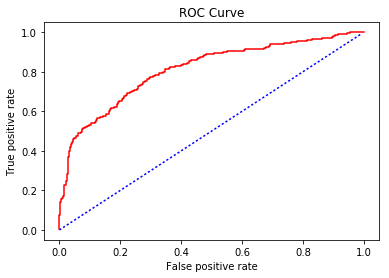

In [13]:
# GridSearch

parameters = {'C':[1e-2,1e-1,1, 10,1e2,1e3]}
clf = LogisticRegression()
clf = GridSearchCV(clf, parameters,scoring='f1')
clf.fit(tVector, trainLabel)
print(clf.best_estimator_)

clf = LogisticRegression(C=0.10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf.fit(tVector, trainLabel)
score_rep(devLabel,clf.predict(dVector),'Logistic Regression with C=10, Tuned by GridSearch')
roc_curve1(devLabel, -clf.predict_proba(dVector)[:,0])


### Section 4.2: Random Forest
Overall best results

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=750, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
{'n_estimators': 750}
make_scorer(f1_score)
Random Forest with n=500, Tuned with GridSearch
---------------------------------------------------------------------------
Accuracy:  0.827
Area under curve of ROC:  0.709719334719
Classification report:

             precision    recall  f1-score   support

      False       0.84      0.95      0.89       740
       True       0.78      0.47      0.58       260

avg / total       0.82      0.83      0.81      1000

---------------------------------------------------------------------------


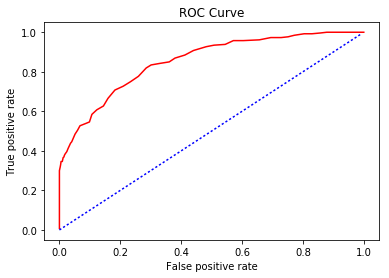

In [14]:
# GridSearch

parameters = {'n_estimators':[10,100, 200, 500, 750, 1000]}
clf = RandomForestClassifier()
clf = GridSearchCV(clf, parameters,scoring='f1')
clf.fit(tVector, trainLabel)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.scorer_)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(tVector, trainLabel)
score_rep(devLabel,clf.predict(dVector),'Random Forest with n=500, Tuned with GridSearch')
roc_curve1(devLabel, -clf.predict_proba(dVector)[:,0])

Random Forest with n=100
---------------------------------------------------------------------------
Accuracy:  0.831
Area under curve of ROC:  0.702442827443
Classification report:

             precision    recall  f1-score   support

      False       0.83      0.97      0.89       740
       True       0.84      0.43      0.57       260

avg / total       0.83      0.83      0.81      1000

---------------------------------------------------------------------------


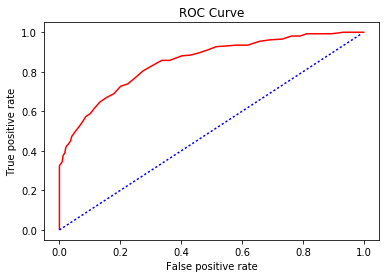

In [15]:
# We could get better results with n=100. Slight difference from above because GridSearch works on just 
# training data

RF = RandomForestClassifier(n_estimators=100)

RF.fit(tVector, trainLabel)
score_rep(devLabel, RF.predict(dVector),'Random Forest with n=100')
roc_curve1(devLabel, -RF.predict_proba(dVector)[:,0])

#RF.fit(tVector_p, trainLabel)
#score_rep(devLabel,RF.predict(dVector_p),'Random Forest')
#roc_curve1(devLabel, -RF.predict_proba(dVector_p)[:,0])

#RF.fit(tVector_s, trainLabel)
#score_rep(devLabel,RF.predict(dVector_s),'Random Forest')
#roc_curve1(devLabel, -RF.predict_proba(dVector_s)[:,0])

#RF.fit(tVector_ps, trainLabel)
#score_rep(devLabel,RF.predict(dVector_ps),'Random Forest')
#roc_curve1(devLabel, -RF.predict_proba(dVector_ps)[:,0])



### Section 4.3 An Ensemble Model

Ensemble Model
---------------------------------------------------------------------------
Accuracy:  0.634
Area under curve of ROC:  0.712785862786
Classification report:

             precision    recall  f1-score   support

      False       0.93      0.55      0.69       740
       True       0.41      0.88      0.55       260

avg / total       0.79      0.63      0.65      1000

---------------------------------------------------------------------------


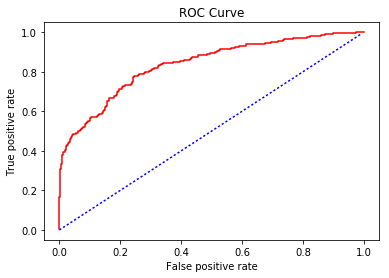

In [16]:
# Create an ensemble model based on LR, NB, RF

# Set up lr_1
lr_1 = LogisticRegression(penalty='l2', C=0.01)
# Set up lr_2
lr_2 = LogisticRegression(penalty='l2', C=0.1)
# Set up lr_3
lr_3 = LogisticRegression(penalty='l2', C=1)
# Set up lr_4
lr_4 = LogisticRegression(penalty='l2', C=10)
# Set up nb
nb_1 = BernoulliNB(alpha=0.001)
# Set up rf
rf_1 = RandomForestClassifier(n_estimators=100)

# Set up ensemble of the models
clf = EnsembleVoteClassifier(clfs=[lr_1, lr_2, lr_3, lr_4, nb_1, rf_1], 
                             voting='soft', weights=[1,1,1,1,1,5])

# Fit training data
clf.fit(tVector,trainLabel)
  
# Probabilities, predictions
devProb = -clf.predict_proba(dVector)
devPred = clf.predict(dVector)

score_rep(devLabel, devPred,'Ensemble Model')
roc_curve1(devLabel, devProb[:,0])


# Section 5: Conclusion

The best feature set seems to be:

1) Text, with CountVectorizer applied
2) This results in a very sparse matrix => we apply SelectPercentile to this to reduce (PCA is also possible)
3) Text is then combined with other features - TIME (Hour and Month) is crucial - but vaderSentiment also helps. These features exhibit more variation than others. Features are scaled to between 0 to 1 to be consistent with text before combined
4) A logistic regression works well, but Random Forest seems best. When tuned, we get C=10 for LR as best, n=100 for Random Forest. 

The best model going by accuracy and f1-score is **Random Forest Classifier with n=500 gives an accuracy of 83%, f1-score of 81% and AUC of 0.71**. However, on AUC, either a **Logistic or our Ensemble Classifier is better with an AUC of 0.73.**

Random Forest with n=100
---------------------------------------------------------------------------
Accuracy:  0.836
Area under curve of ROC:  0.730769230769
Classification report:

             precision    recall  f1-score   support

      False       0.85      0.95      0.90       740
       True       0.78      0.51      0.62       260

avg / total       0.83      0.84      0.82      1000

---------------------------------------------------------------------------


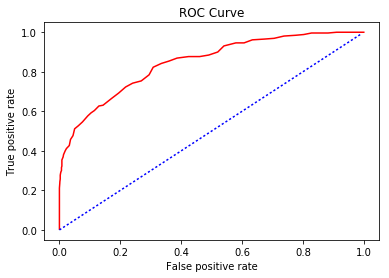

In [17]:
RF = RandomForestClassifier(n_estimators=100)

RF.fit(tVector, trainLabel)
score_rep(devLabel, RF.predict(dVector),'Random Forest with n=100')
roc_curve1(devLabel, -RF.predict_proba(dVector)[:,0])
